In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

import visual_bars.generate_visual_bars_data as vbd
from cfl.experiment import Experiment

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from keras import Sequential
from keras.layers import Dense, Dropout

# NSW - Education, Age, Treat

## CFL set up

In [92]:
def build_network(trial):

    # vary number of layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    model = Sequential()

    for i in range(n_layers):
        # vary size of each layer
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 512, log=True)
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.5)
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))

    return model

In [94]:
def objective(trial):

    # define the parameters for a CFL Experiment
    data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

    CDE_params = {
        'model'        : 'CondExpDIY',
        'model_params' : {
            'optuna_callback' : TFKerasPruningCallback(trial, "val_loss"),
            'optuna_trial'    : trial,
            'build_network'     : build_network,

            'batch_size'      : trial.suggest_int("batch_size", 16, 128),
            'n_epochs'        : 100,
            'optimizer'       : 'adam',
            'opt_config'      : {'learning_rate' : trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)},
            'loss'            : 'mean_squared_error',
            'best'            : True,
            'verbose'         : 0,
            'early_stopping'  : True,
        }
    }

    block_names = ['CondDensityEstimator']
    block_params = [CDE_params]

    my_exp = Experiment(X_train=X,
                        Y_train=Y,
                        in_sample_idx=in_sample_idx,
                        out_sample_idx=out_sample_idx,
                        data_info=data_info,
                        block_names=block_names,
                        block_params=block_params,
                        verbose=0,
                        results_path=None) # we don't want to save 100's of results

    train_results = my_exp.train()
    score = train_results['CondDensityEstimator']['val_loss'][-1]
    return score

In [95]:
import numpy as np
import pandas as pd

# read stata file
data = pd.read_stata('data/nsw.dta')
data = data.drop(columns=['data_id'])

In [96]:
# drop the first column

# drop NaNs
data = data.dropna()
Y = (data['re78']-data['re75']).values.reshape(-1, 1)

# binning Y with 10 bins

# Y = pd.qcut(Y.flatten(), 700, labels=False, duplicates="drop").reshape(-1, 1)


X = data[['treat','age', 'education']].values

column = ['treat','age', 'education']

# standardize the data
import sklearn.preprocessing as skp

scaler = skp.StandardScaler()
X = scaler.fit_transform(X)
# Y = scaler.fit_transform(Y)


print(X.shape)
print(Y.shape)

# define train and validation sets to remain constant across tuning
in_sample_idx, out_sample_idx = train_test_split(np.arange(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)

(722, 3)
(722, 1)


[I 2025-02-13 04:20:50,315] A new study created in memory with name: no-name-58743d0b-5dbe-42b6-bf7f-b9057fc08b90


Block: verbose not specified in input, defaulting to 1


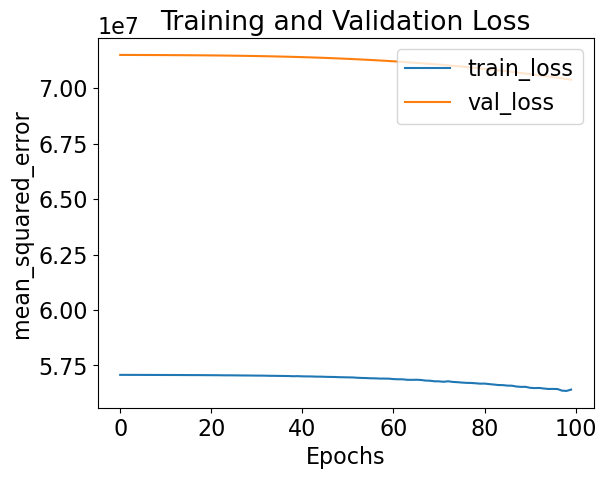

23/23 [==============================] - 0s 3ms/step


[I 2025-02-13 04:21:11,696] Trial 0 finished with value: 70382424.0 and parameters: {'batch_size': 58, 'learning_rate': 0.0006616161875457395, 'n_layers': 2, 'n_units_l0': 8, 'dropout_l0': 0.00562445696639946, 'n_units_l1': 29, 'dropout_l1': 0.4088627907706236}. Best is trial 0 with value: 70382424.0.


Block: verbose not specified in input, defaulting to 1


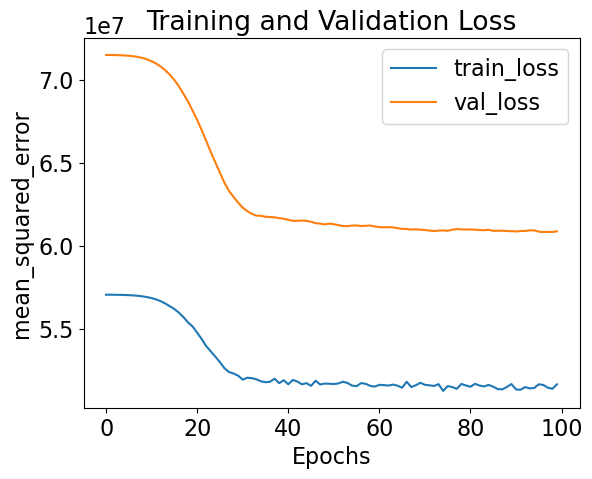

23/23 [==============================] - 0s 2ms/step


[I 2025-02-13 04:21:28,193] Trial 1 finished with value: 60885592.0 and parameters: {'batch_size': 99, 'learning_rate': 0.0009055865402055741, 'n_layers': 3, 'n_units_l0': 15, 'dropout_l0': 0.0554228493919629, 'n_units_l1': 224, 'dropout_l1': 0.05237489496786102, 'n_units_l2': 180, 'dropout_l2': 0.023499192243402633}. Best is trial 1 with value: 60885592.0.


Block: verbose not specified in input, defaulting to 1


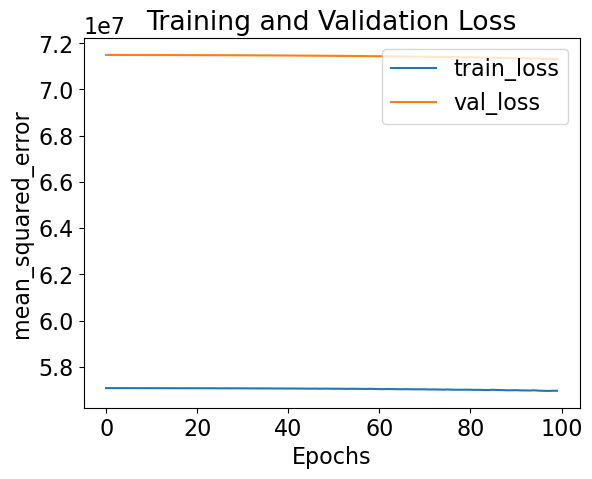

23/23 [==============================] - 0s 2ms/step


[I 2025-02-13 04:21:49,414] Trial 2 finished with value: 71319176.0 and parameters: {'batch_size': 100, 'learning_rate': 4.913434553815877e-05, 'n_layers': 3, 'n_units_l0': 335, 'dropout_l0': 0.3002378588540578, 'n_units_l1': 287, 'dropout_l1': 0.006405089402734543, 'n_units_l2': 4, 'dropout_l2': 0.23914220348961013}. Best is trial 1 with value: 60885592.0.


Block: verbose not specified in input, defaulting to 1


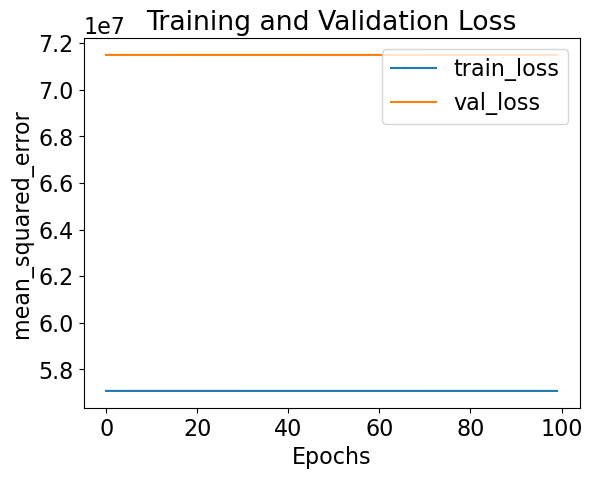

23/23 [==============================] - 0s 2ms/step


[I 2025-02-13 04:22:07,483] Trial 3 finished with value: 71497088.0 and parameters: {'batch_size': 35, 'learning_rate': 1.569909897573465e-05, 'n_layers': 5, 'n_units_l0': 61, 'dropout_l0': 0.36607523895492267, 'n_units_l1': 70, 'dropout_l1': 0.399437575375267, 'n_units_l2': 5, 'dropout_l2': 0.07265456170840501, 'n_units_l3': 14, 'dropout_l3': 0.4822274379052912, 'n_units_l4': 41, 'dropout_l4': 0.18884703768118677}. Best is trial 1 with value: 60885592.0.


Block: verbose not specified in input, defaulting to 1


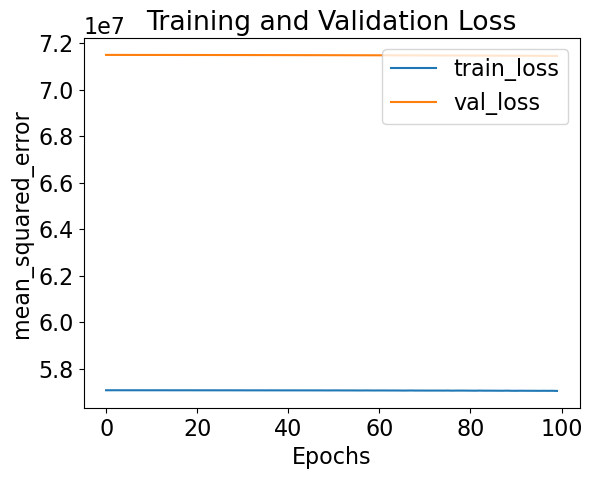

23/23 [==============================] - 0s 2ms/step


[I 2025-02-13 04:22:25,731] Trial 4 finished with value: 71454872.0 and parameters: {'batch_size': 86, 'learning_rate': 0.0005081359449358131, 'n_layers': 2, 'n_units_l0': 4, 'dropout_l0': 0.22331202645409343, 'n_units_l1': 10, 'dropout_l1': 0.21293180798593286}. Best is trial 1 with value: 60885592.0.


Block: verbose not specified in input, defaulting to 1


[I 2025-02-13 04:22:27,112] Trial 5 pruned. Trial was pruned at epoch 2.


Block: verbose not specified in input, defaulting to 1


[I 2025-02-13 04:22:28,348] Trial 6 pruned. Trial was pruned at epoch 0.


Block: verbose not specified in input, defaulting to 1


[I 2025-02-13 04:22:30,851] Trial 7 pruned. Trial was pruned at epoch 7.


Block: verbose not specified in input, defaulting to 1


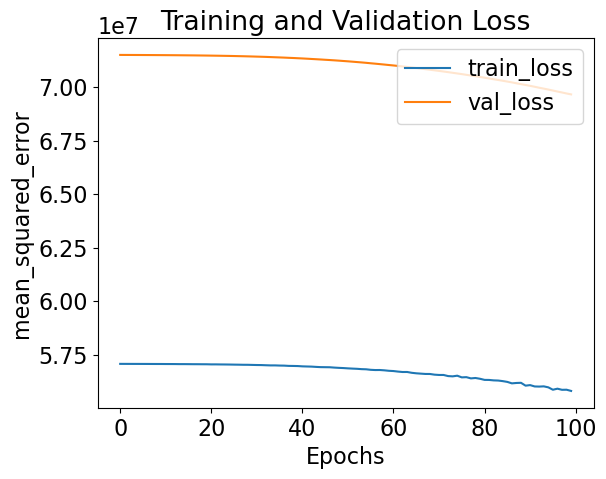

23/23 [==============================] - 0s 3ms/step


[I 2025-02-13 04:22:50,323] Trial 8 finished with value: 69653784.0 and parameters: {'batch_size': 40, 'learning_rate': 0.0004957650500267657, 'n_layers': 2, 'n_units_l0': 32, 'dropout_l0': 0.3710114981503465, 'n_units_l1': 10, 'dropout_l1': 0.15003678848365654}. Best is trial 1 with value: 60885592.0.


Block: verbose not specified in input, defaulting to 1


[I 2025-02-13 04:22:52,610] Trial 9 pruned. Trial was pruned at epoch 0.


In [97]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10)

In [98]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  60885592.0
  Params: 
    batch_size: 99
    learning_rate: 0.0009055865402055741
    n_layers: 3
    n_units_l0: 15
    dropout_l0: 0.0554228493919629
    n_units_l1: 224
    dropout_l1: 0.05237489496786102
    n_units_l2: 180
    dropout_l2: 0.023499192243402633


## Two cluster

All results from this run will be saved to demo_results\experiment0020
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


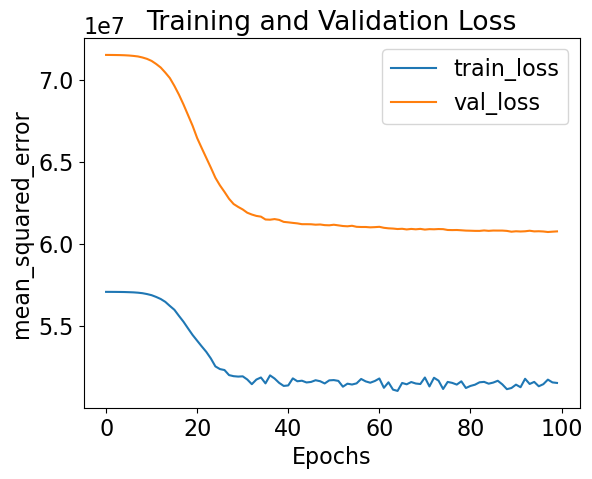

23/23 [==============================] - 0s 4ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


c:\Users\huang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [52]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 2},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd
data_cluster = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
data_cluster['rediff'] = data_cluster['re78']-data_cluster['re75']

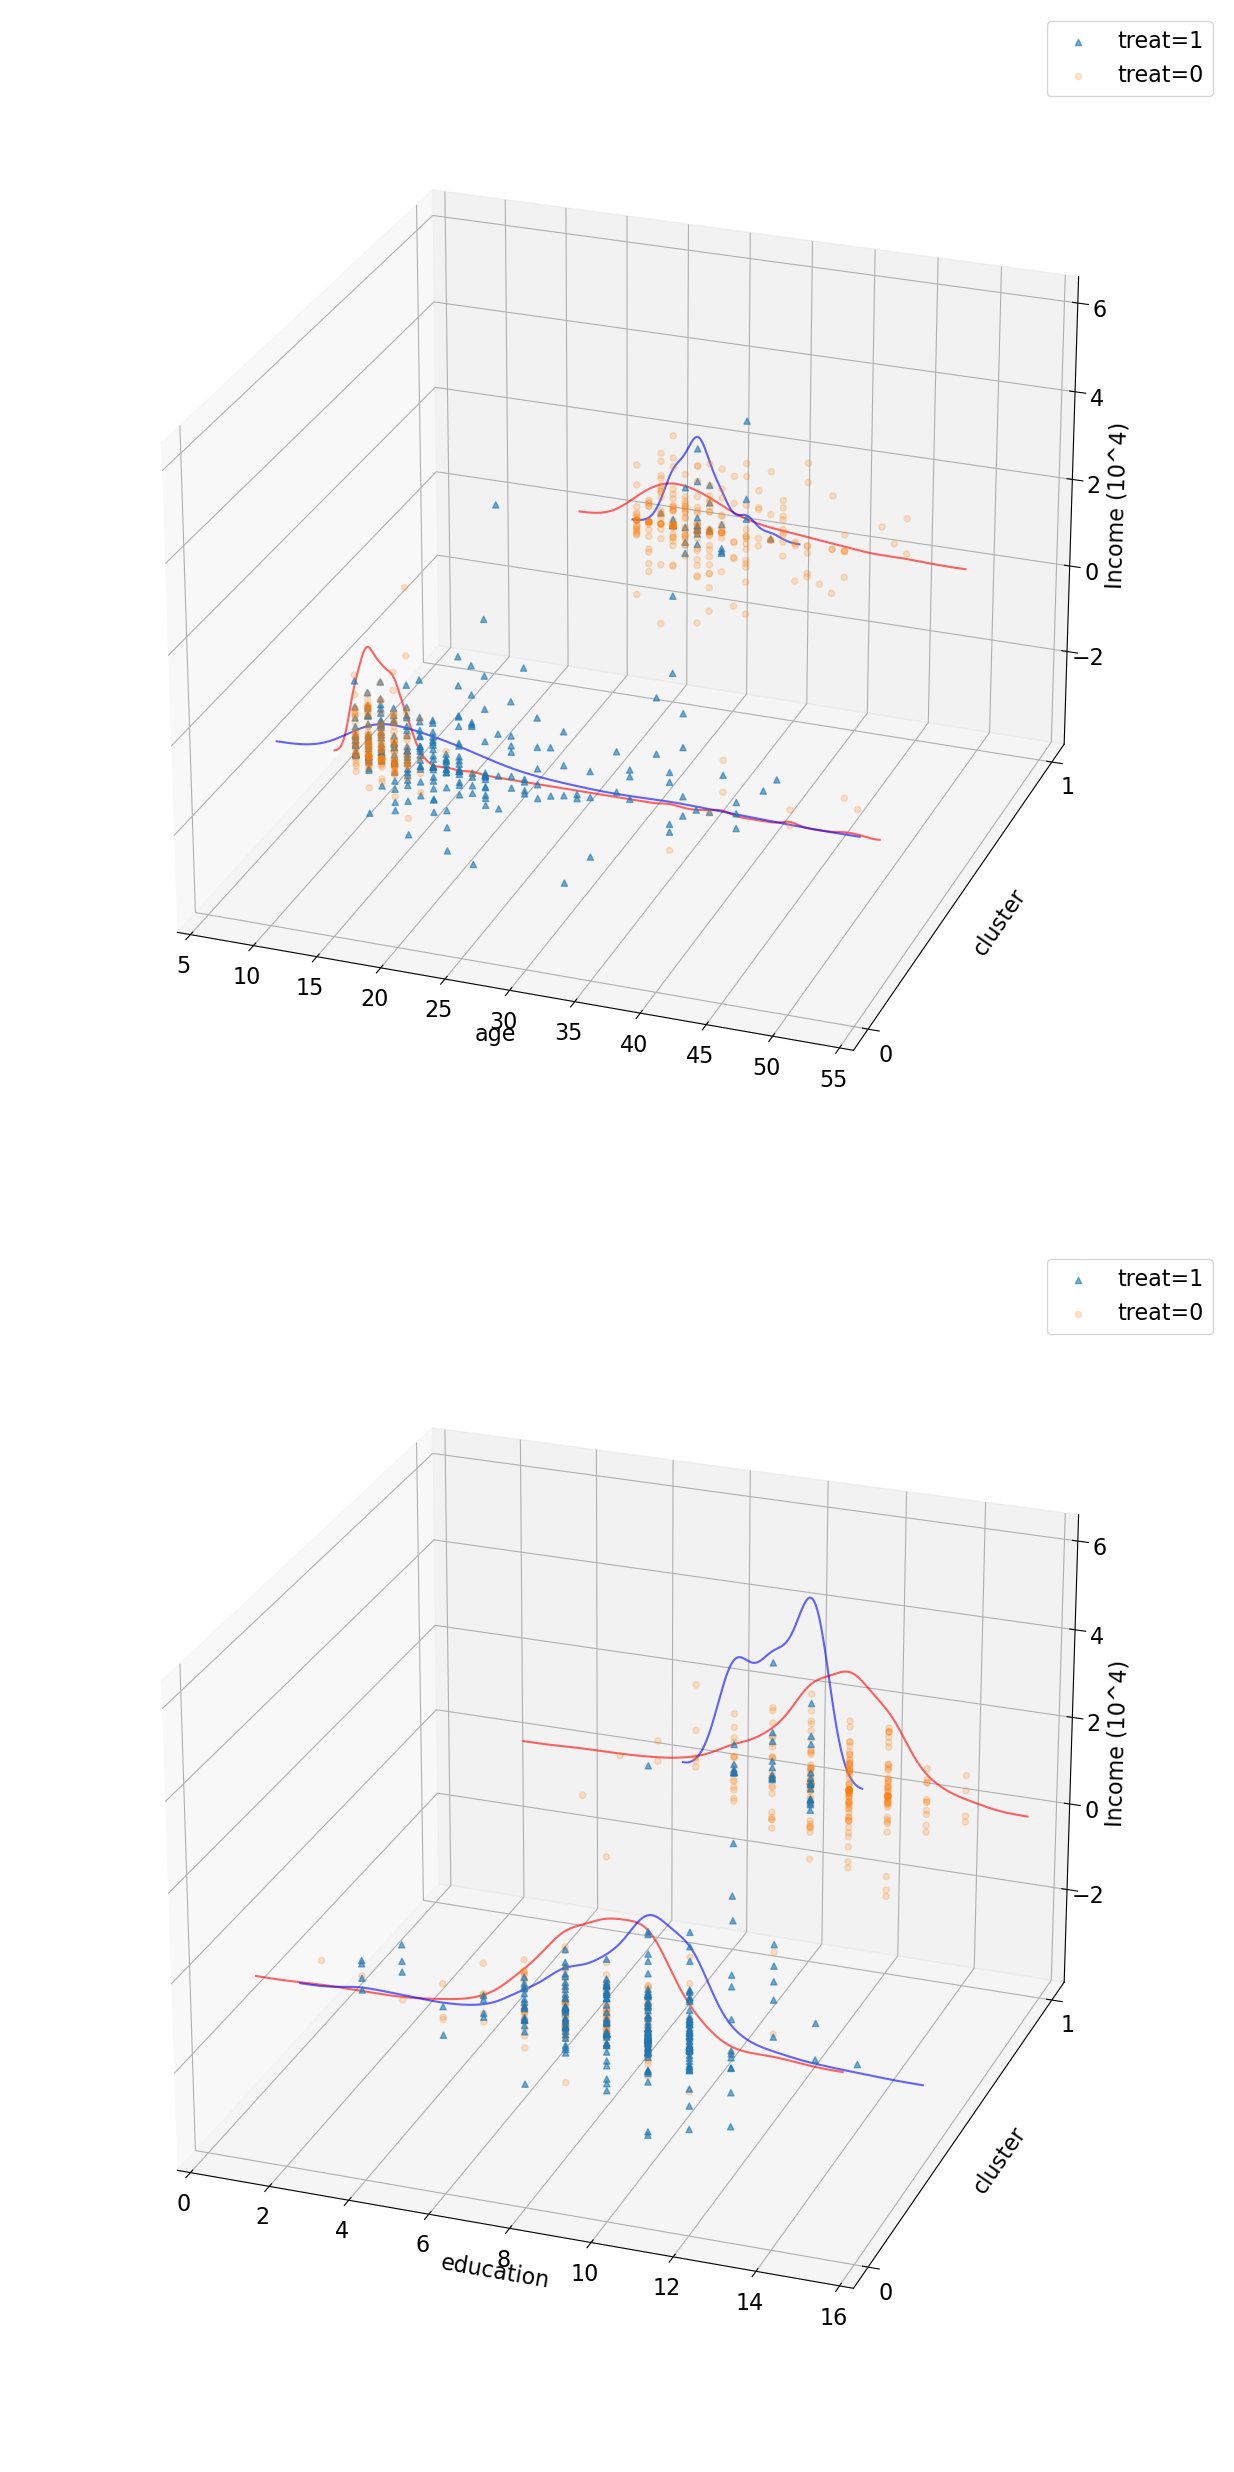

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from statsmodels.nonparametric.kde import KDEUnivariate

data_cluster = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
data_cluster['rediff'] = data_cluster['re78']-data_cluster['re75']

fig = plt.figure(figsize=(15,25))

# First subplot (age vs. cluster vs. rediff)
ax = fig.add_subplot(2, 1, 1, projection='3d')

# Plot 'treat=1' first (so it appears behind)
ax.scatter(data_cluster[data_cluster['treat'] == 1]['age'], 
           data_cluster[data_cluster['treat'] == 1]['cluster'], 
           data_cluster[data_cluster['treat'] == 1]['rediff'], 
           marker='^', label='treat=1', alpha=0.6)

# Plot 'treat=0' second (so it appears on top)
ax.scatter(data_cluster[data_cluster['treat'] == 0]['age'], 
           data_cluster[data_cluster['treat'] == 0]['cluster'], 
           data_cluster[data_cluster['treat'] == 0]['rediff'], 
           marker='o', label='treat=0', alpha=0.2)  # Increase alpha for visibility

# kde
for i in data_cluster['cluster'].unique():
    kde = KDEUnivariate(data_cluster[(data_cluster['cluster'] == i)&(data_cluster['treat']==0)]['age'])
    kde.fit()
    ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='red', alpha=0.6)
    kde = KDEUnivariate(data_cluster[(data_cluster['cluster'] == i)&(data_cluster['treat']==1)]['age'])
    kde.fit()
    ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='blue', alpha=0.6)

ax.set_yticks([0, 1])
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
ax.set_xlim(5, max(data_cluster['age']))
ax.set_xticks(range(5, max(data_cluster['age'])+1, 5))
ax.set_xlabel('age')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)')
ax.view_init(elev=25, azim=-70)
ax.legend()
ax.set_box_aspect(aspect=None, zoom=0.9)

# Second subplot (education vs. cluster vs. rediff)
ax = fig.add_subplot(2, 1, 2, projection='3d')

# Plot 'treat=1' first (so it appears behind)
ax.scatter(data_cluster[data_cluster['treat'] == 1]['education'], 
           data_cluster[data_cluster['treat'] == 1]['cluster'], 
           data_cluster[data_cluster['treat'] == 1]['rediff'], 
           marker='^', label='treat=1', alpha=0.6)

# Plot 'treat=0' second (so it appears on top)
ax.scatter(data_cluster[data_cluster['treat'] == 0]['education'], 
           data_cluster[data_cluster['treat'] == 0]['cluster'], 
           data_cluster[data_cluster['treat'] == 0]['rediff'], 
           marker='o', label='treat=0', alpha=0.2)  # Increase alpha for visibility


# kde
for i in data_cluster['cluster'].unique():
    kde = KDEUnivariate(data_cluster[(data_cluster['cluster'] == i)&(data_cluster['treat']==0)]['education'])
    kde.fit()
    ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='red', alpha=0.6)
    kde = KDEUnivariate(data_cluster[(data_cluster['cluster'] == i)&(data_cluster['treat']==1)]['education'])
    kde.fit()
    ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='blue', alpha=0.6)


ax.set_yticks([0, 1])
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
ax.set_xlim(min(kde.support), max(data_cluster['education']))
ax.set_xticks(range(0, max(data_cluster['education'])+1, 2))

ax.set_xlabel('education')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)')
ax.view_init(elev=25, azim=-70)
ax.legend()
ax.set_box_aspect(aspect=None, zoom=0.9)

# reduce the vertical space between the two subplots
plt.subplots_adjust(hspace=0)

plt.tight_layout()

# save
# plt.savefig('output/nsw_3d_2.png')

plt.show()


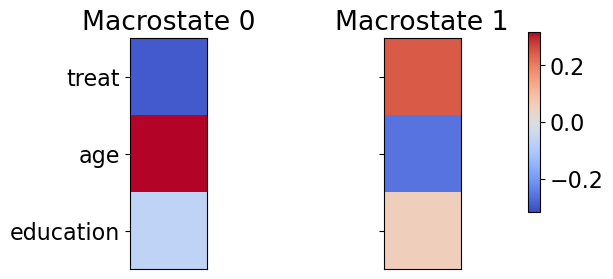

In [178]:
# visualize cause side macrostates
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0010', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

model = smf.ols(formula = 'treat ~ 1 + age + education + black + hispanic + married + nodegree + re75', data = data_cluster).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  treat   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.130
Date:                Thu, 26 Sep 2024   Prob (F-statistic):              0.342
Time:                        05:25:12   Log-Likelihood:                -508.52
No. Observations:                 722   AIC:                             1033.
Df Residuals:                     714   BIC:                             1070.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6041      0.207      2.917      0.004       0.198       1.011
age           -0.0004      0.003     -0.134      0.894      -0.006       0.005
education     -0.0057      0.014     -0.395      0.693      -0.034       0.023
black         -0.0238      0.064     -0.371      0.711      -0.150       0.102
hispanic      -0.0603      0.084     -0.721      0.471      -0.224       0.104
married        0.0223      0.052      0.428      0.669      -0.080       0.125
nodegree      -0.1295      0.059     -2.187      0.029      -0.246      -0.013
re75       -7.539e-07   3.73e-06     -0.202      0.840   -8.09e-06    6.58e-06
==============================================================================
Omnibus:                     3214.404   Durbin-Watson:                   0.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.692
Skew:                           0.357   Prob(JB):                     7.55e-26
Kurtosis:                       1.174   Cond. No.                     6.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# smf
import statsmodels.formula.api as smf
import statsmodels.api as sm

data_cluster['age_dummy'] = data_cluster['age'].apply(lambda x: 1 if x > data_cluster['age'].mean() else 0)

model = smf.ols(formula = 'rediff ~ 1 + treat + age_dummy + age_dummy*treat', data = data_cluster).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rediff   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.216
Date:                Thu, 26 Sep 2024   Prob (F-statistic):             0.0224
Time:                        05:31:38   Log-Likelihood:                -7452.9
No. Observations:                 722   AIC:                         1.491e+04
Df Residuals:                     718   BIC:                         1.493e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2790.3659    476.311      5.858      0.000    1855.237    3725.495
treat            -409.6660    742.277     -0.552      0.581   -1866.959    1047.627
age_dummy       -1670.1359    721.937     -2.313      0.021   -3087.495    -252.776
age_dummy:treat  2889.3416   1125.781      2.567      0.010     679.125    5099.558
==============================================================================
Omnibus:                      155.224   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1456.851
Skew:                           0.671   Prob(JB):                         0.00
Kurtosis:                       9.828   Cond. No.                         6.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# smf
import statsmodels.formula.api as smf
import statsmodels.api as sm

data_cluster['educ_dummy'] = data_cluster['education'].apply(lambda x: 1 if x > data_cluster['education'].mean() else 0)

model = smf.ols(formula = 'rediff ~ 1 + treat + educ_dummy + educ_dummy*treat + age', data = data_cluster).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rediff   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.012
Date:                Wed, 25 Sep 2024   Prob (F-statistic):             0.0910
Time:                        23:47:03   Log-Likelihood:                -7453.7
No. Observations:                 722   AIC:                         1.492e+04
Df Residuals:                     717   BIC:                         1.494e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3294.4386   1105.270      2.981      0.003    1124.487    5464.391
treat             -292.1596    793.878     -0.368      0.713   -1850.763    1266.443
educ_dummy       -1501.3249    722.011     -2.079      0.038   -2918.834     -83.816
educ_dummy:treat  2347.0419   1120.717      2.094      0.037     146.764    4547.320
age                -21.8908     41.770     -0.524      0.600    -103.897      60.115
==============================================================================
Omnibus:                      160.079   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1466.814
Skew:                           0.711   Prob(JB):                         0.00
Kurtosis:                       9.836   Cond. No.                         132.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Three cluster

All results from this run will be saved to demo_results\experiment0011
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


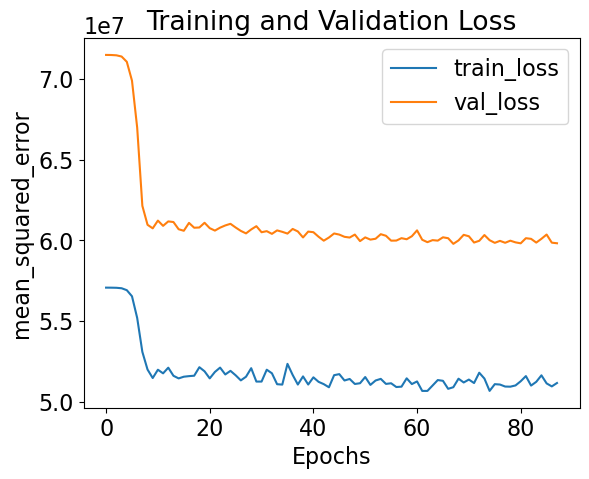

23/23 [==============================] - 0s 2ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


c:\Users\huang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [179]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd
data_cluster = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
data_cluster['rediff'] = data_cluster['re78']-data_cluster['re75']

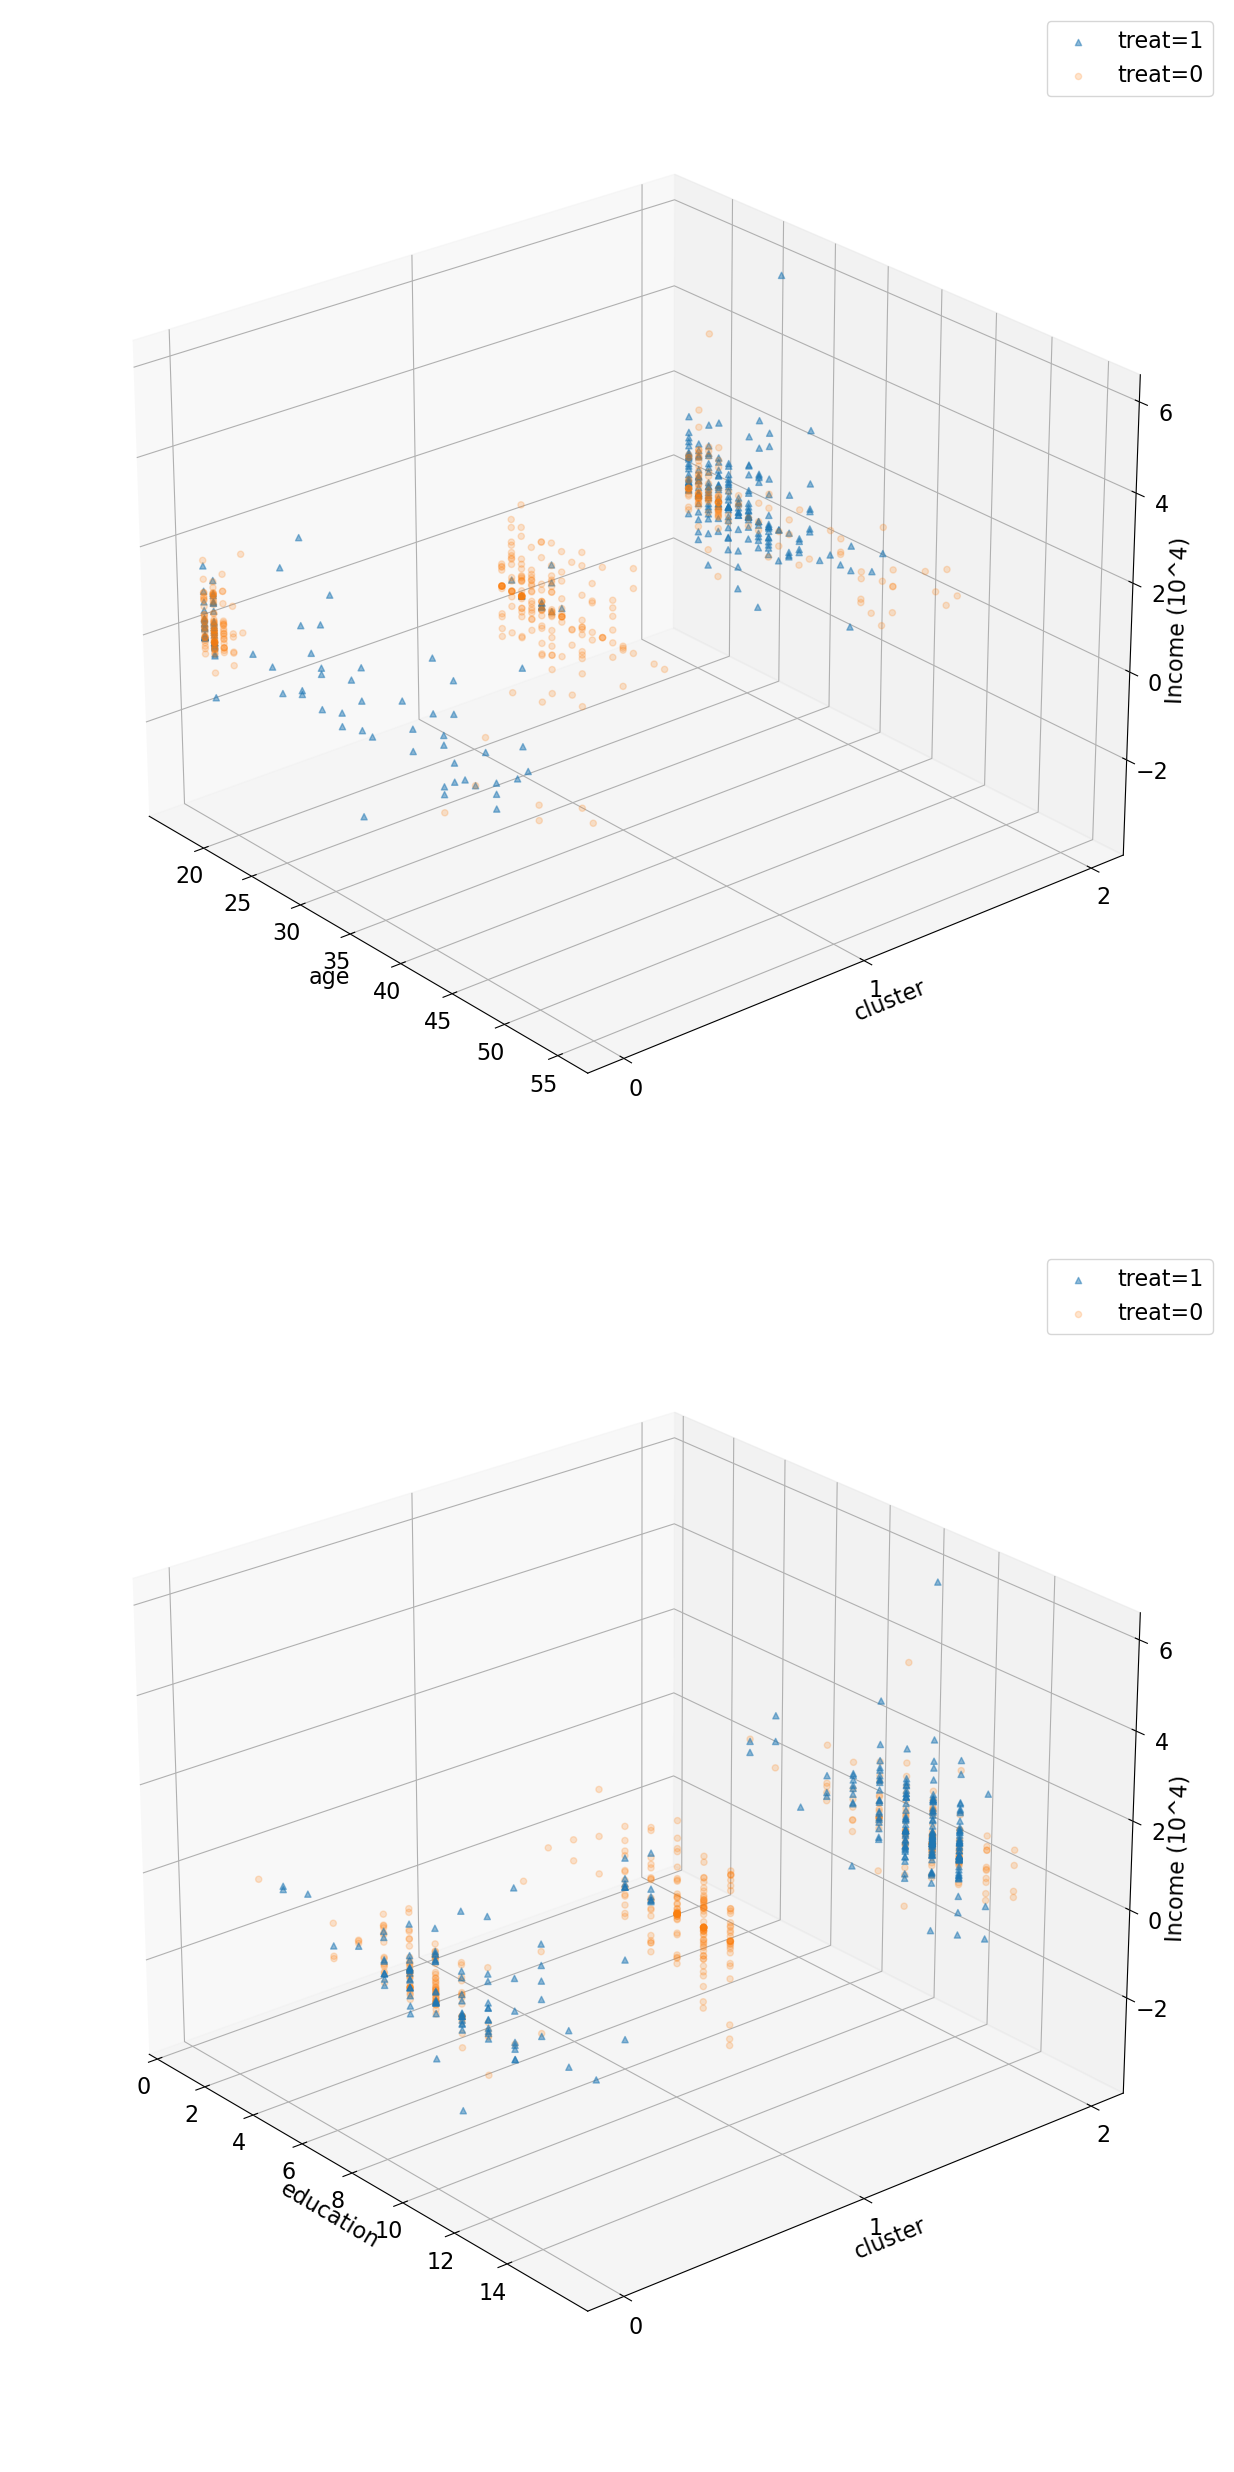

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

data_cluster = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
data_cluster['rediff'] = data_cluster['re78']-data_cluster['re75']

fig = plt.figure(figsize=(15,25))

ax = fig.add_subplot(2, 1, 1,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['age'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['rediff'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster[data_cluster['treat']==0]['age'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['rediff'], marker = 'o', label = 'treat=0', alpha = 0.2)
# Set y-axis to multiples of 10
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# # label that it is scientific notation
# ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks([0,1,2])
ax.set_xticks(range(20,60,5))
ax.set_xlabel('age')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)', rotation=90)
ax.zaxis.labelpad=-0 # <- change the value here
ax.view_init(elev=25, azim=-40)
ax.set_box_aspect(aspect=None, zoom=0.9)
ax.legend()

ax = fig.add_subplot(2, 1, 2,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['education'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['rediff'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster[data_cluster['treat']==0]['education'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['rediff'], marker = 'o', label = 'treat=0', alpha = 0.2)
ax.set_yticks([0,1,2])
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))

ax.set_xlabel('education')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)', rotation=90)
ax.zaxis.labelpad=-0 # <- change the value here
ax.set_xticks(range(0,16,2))
ax.view_init(elev=25, azim=-40)
ax.legend()
ax.set_box_aspect(aspect=None, zoom=0.9)

# reduce the vertical space between the two subplots
plt.subplots_adjust(hspace=0.1)

plt.tight_layout()

# save
plt.savefig('output/nsw_3d_3.png')

plt.show()

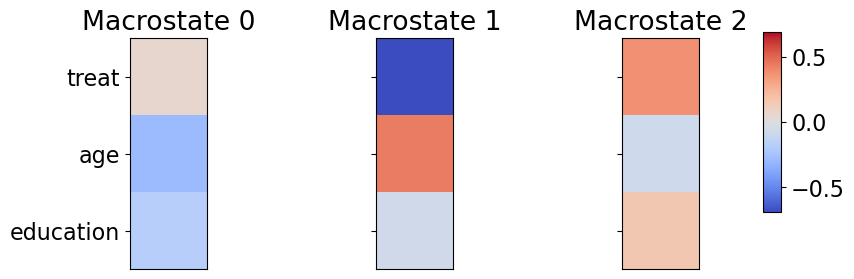

In [181]:
# visualize cause side macrostates
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0011', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

## Four Cluster

All results from this run will be saved to demo_results\experiment0012
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


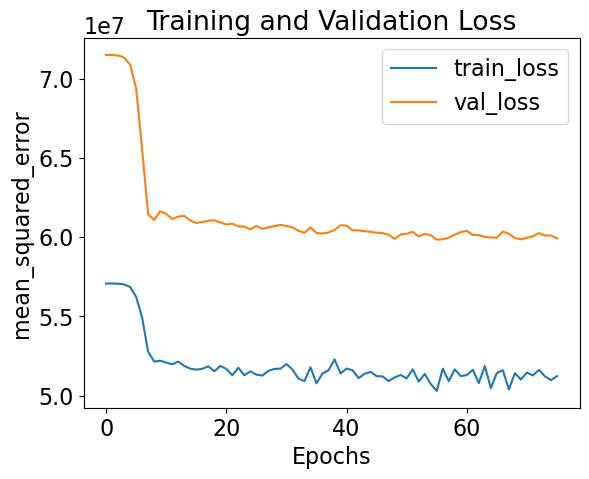

23/23 [==============================] - 0s 3ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


c:\Users\huang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [182]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 4},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd
data_cluster = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
data_cluster['rediff'] = data_cluster['re78']-data_cluster['re75']

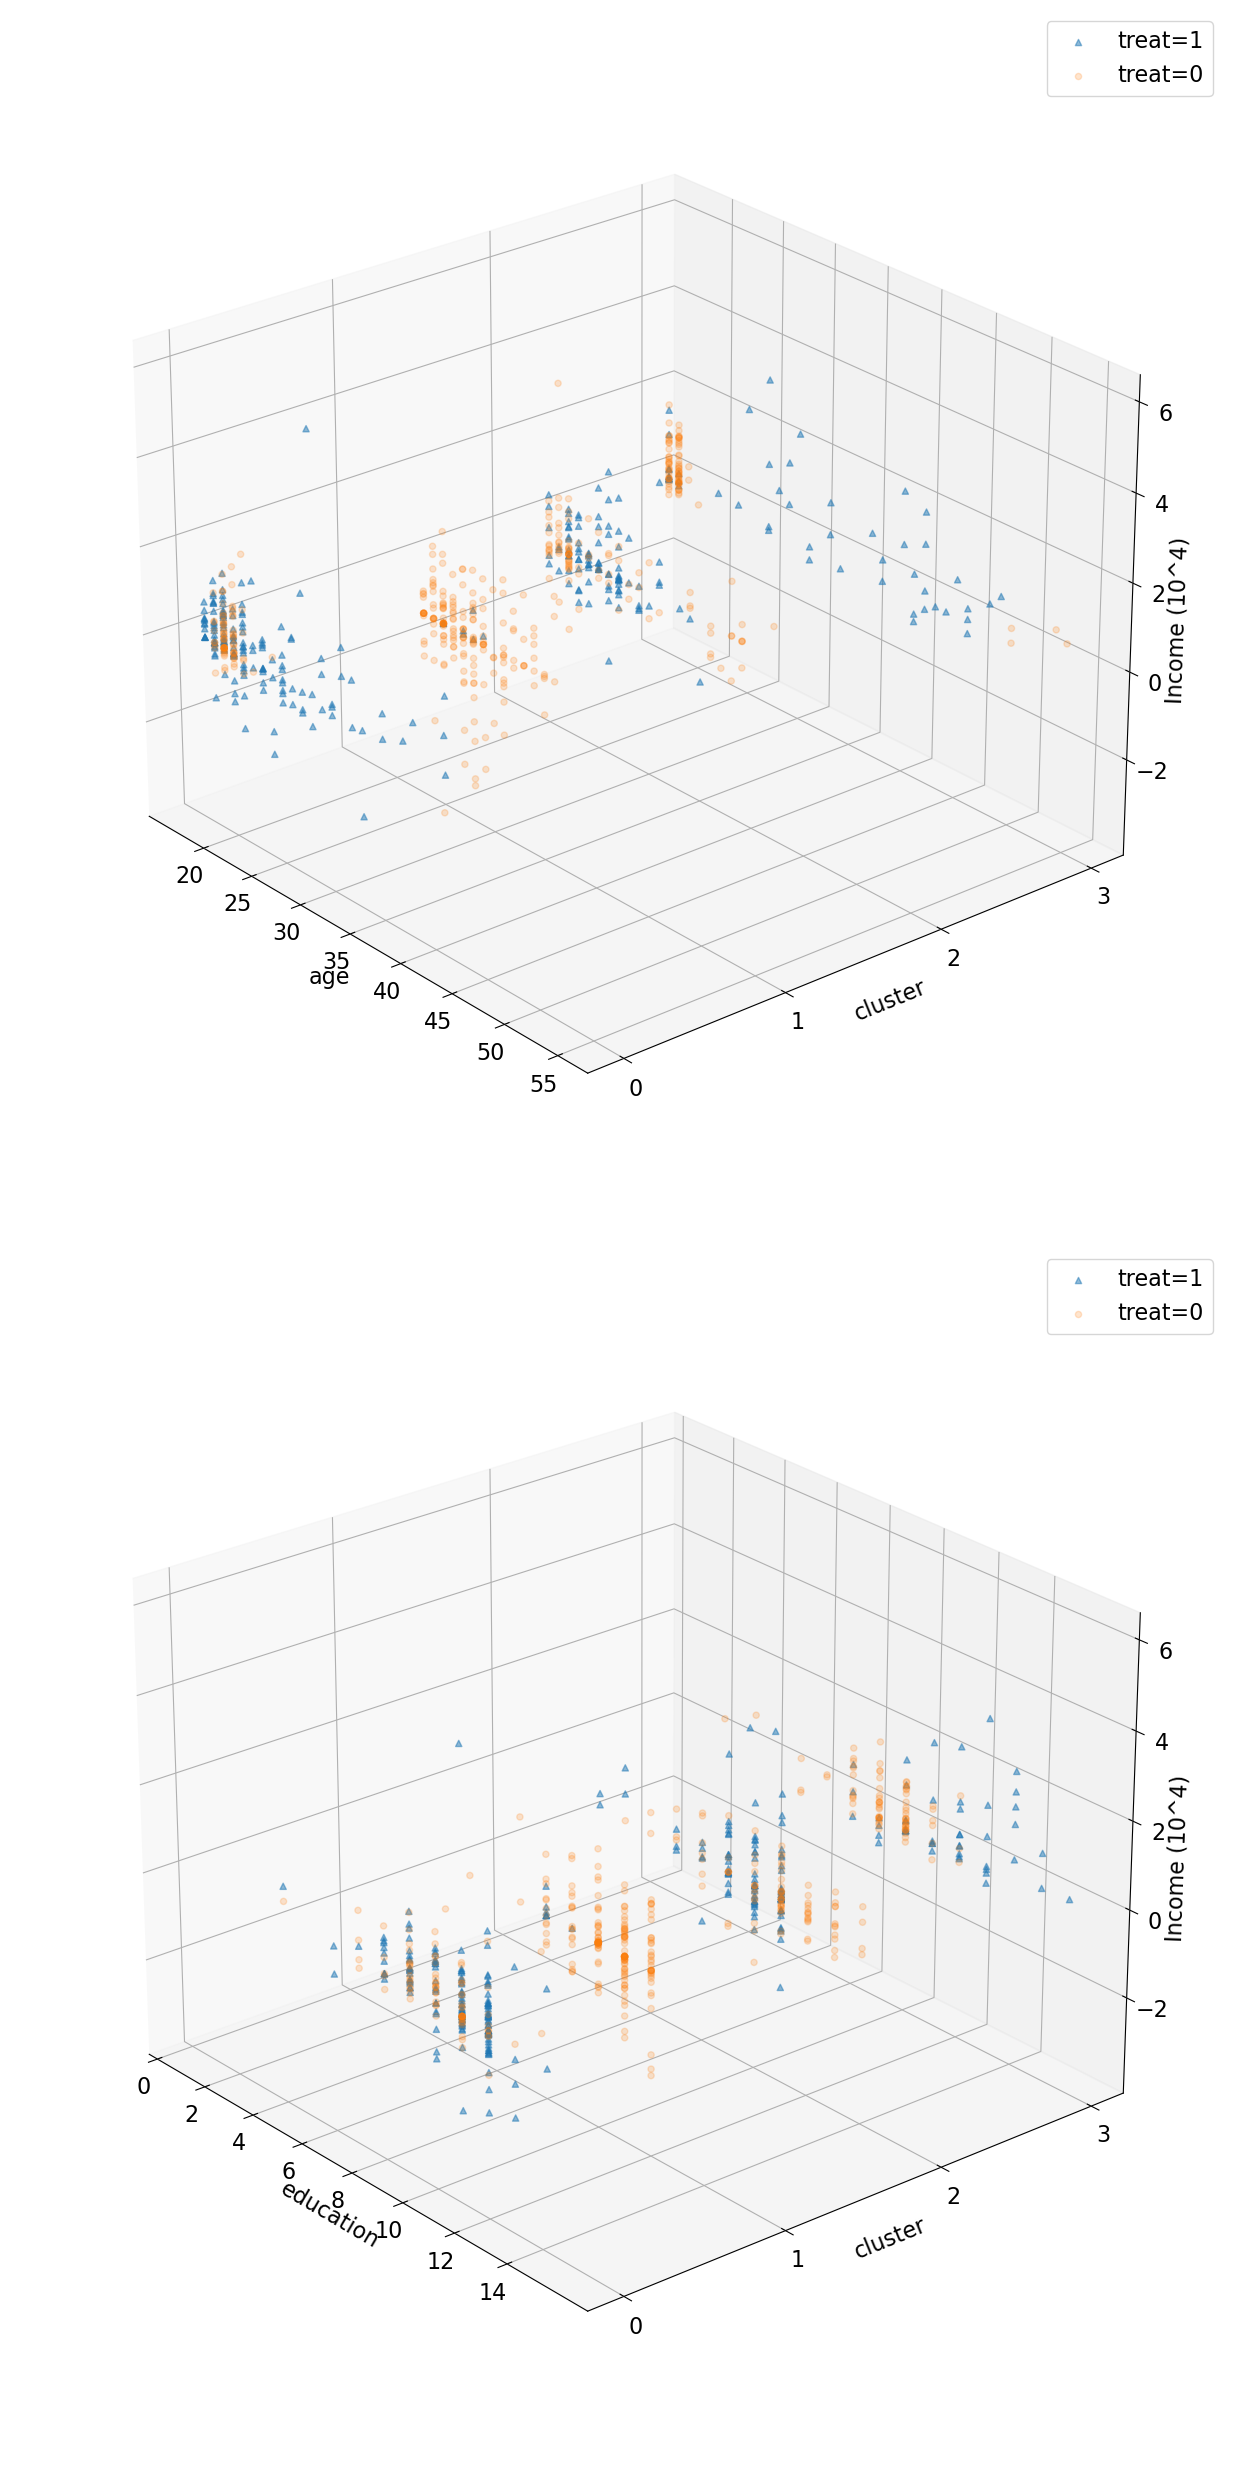

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

data_cluster = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
data_cluster['rediff'] = data_cluster['re78']-data_cluster['re75']

fig = plt.figure(figsize=(15,25))

ax = fig.add_subplot(2, 1, 1,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['age'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['rediff'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster[data_cluster['treat']==0]['age'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['rediff'], marker = 'o', label = 'treat=0', alpha = 0.2)
# Set y-axis to multiples of 10
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# # label that it is scientific notation
# ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks([0,1,2,3])
ax.set_xticks(range(20,60,5))
ax.set_xlabel('age')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)', rotation=90)
ax.zaxis.labelpad=-0 # <- change the value here
ax.view_init(elev=25, azim=-40)
ax.set_box_aspect(aspect=None, zoom=0.9)
ax.legend()

ax = fig.add_subplot(2, 1, 2,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['education'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['rediff'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster[data_cluster['treat']==0]['education'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['rediff'], marker = 'o', label = 'treat=0', alpha = 0.2)
ax.set_yticks([0,1,2,3])
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))

ax.set_xlabel('education')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)', rotation=90)
ax.zaxis.labelpad=-0 # <- change the value here
ax.set_xticks(range(0,16,2))
ax.view_init(elev=25, azim=-40)
ax.legend()
ax.set_box_aspect(aspect=None, zoom=0.9)

# reduce the vertical space between the two subplots
plt.subplots_adjust(hspace=0.1)

plt.tight_layout()

# save
plt.savefig('output/nsw_3d_4.png')

plt.show()

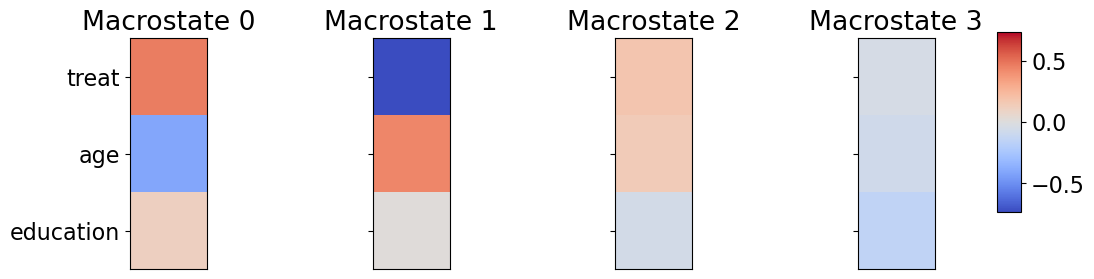

In [184]:
# visualize cause side macrostates
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0012', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

# Subplot Replication

All results from this run will be saved to demo_results\experiment0028
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


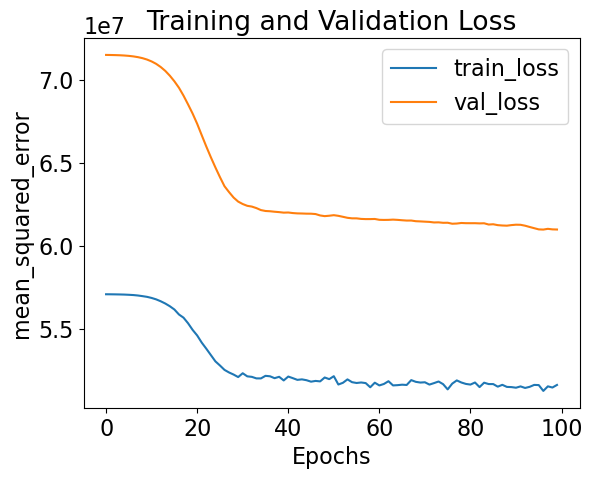

23/23 [==============================] - 0s 2ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


c:\Users\huang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [99]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 2},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd
data_cluster2 = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
data_cluster2['rediff'] = data_cluster2['re78']-data_cluster2['re75']
# save the data
data_cluster2.to_csv('data/nsw_clustered2.csv')

All results from this run will be saved to demo_results\experiment0029
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


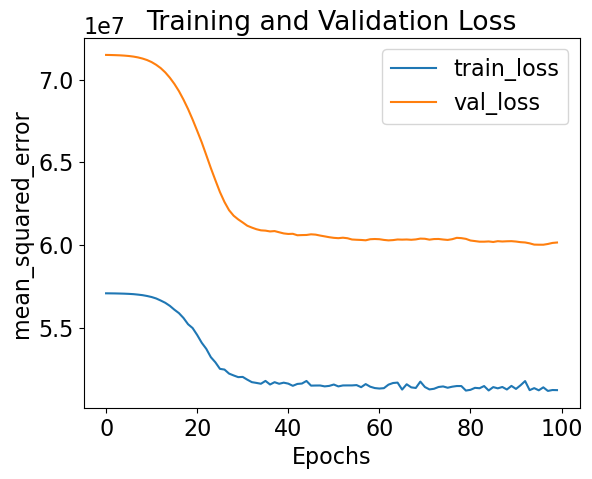

23/23 [==============================] - 0s 4ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


c:\Users\huang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [100]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd
data_cluster3 = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
data_cluster3['rediff'] = data_cluster3['re78']-data_cluster3['re75']
# save the data
data_cluster3.to_csv('data/nsw_clustered3.csv')

All results from this run will be saved to demo_results\experiment0030
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


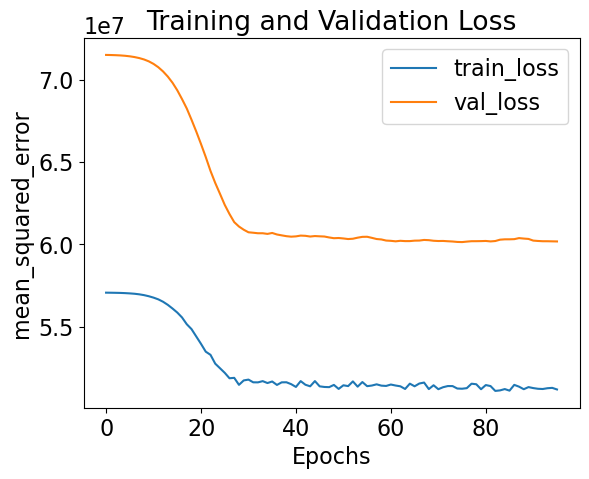

23/23 [==============================] - 0s 5ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


c:\Users\huang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [101]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 4},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd
data_cluster4 = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
data_cluster4['rediff'] = data_cluster4['re78']-data_cluster4['re75']
# save the data
data_cluster4.to_csv('data/nsw_clustered4.csv')

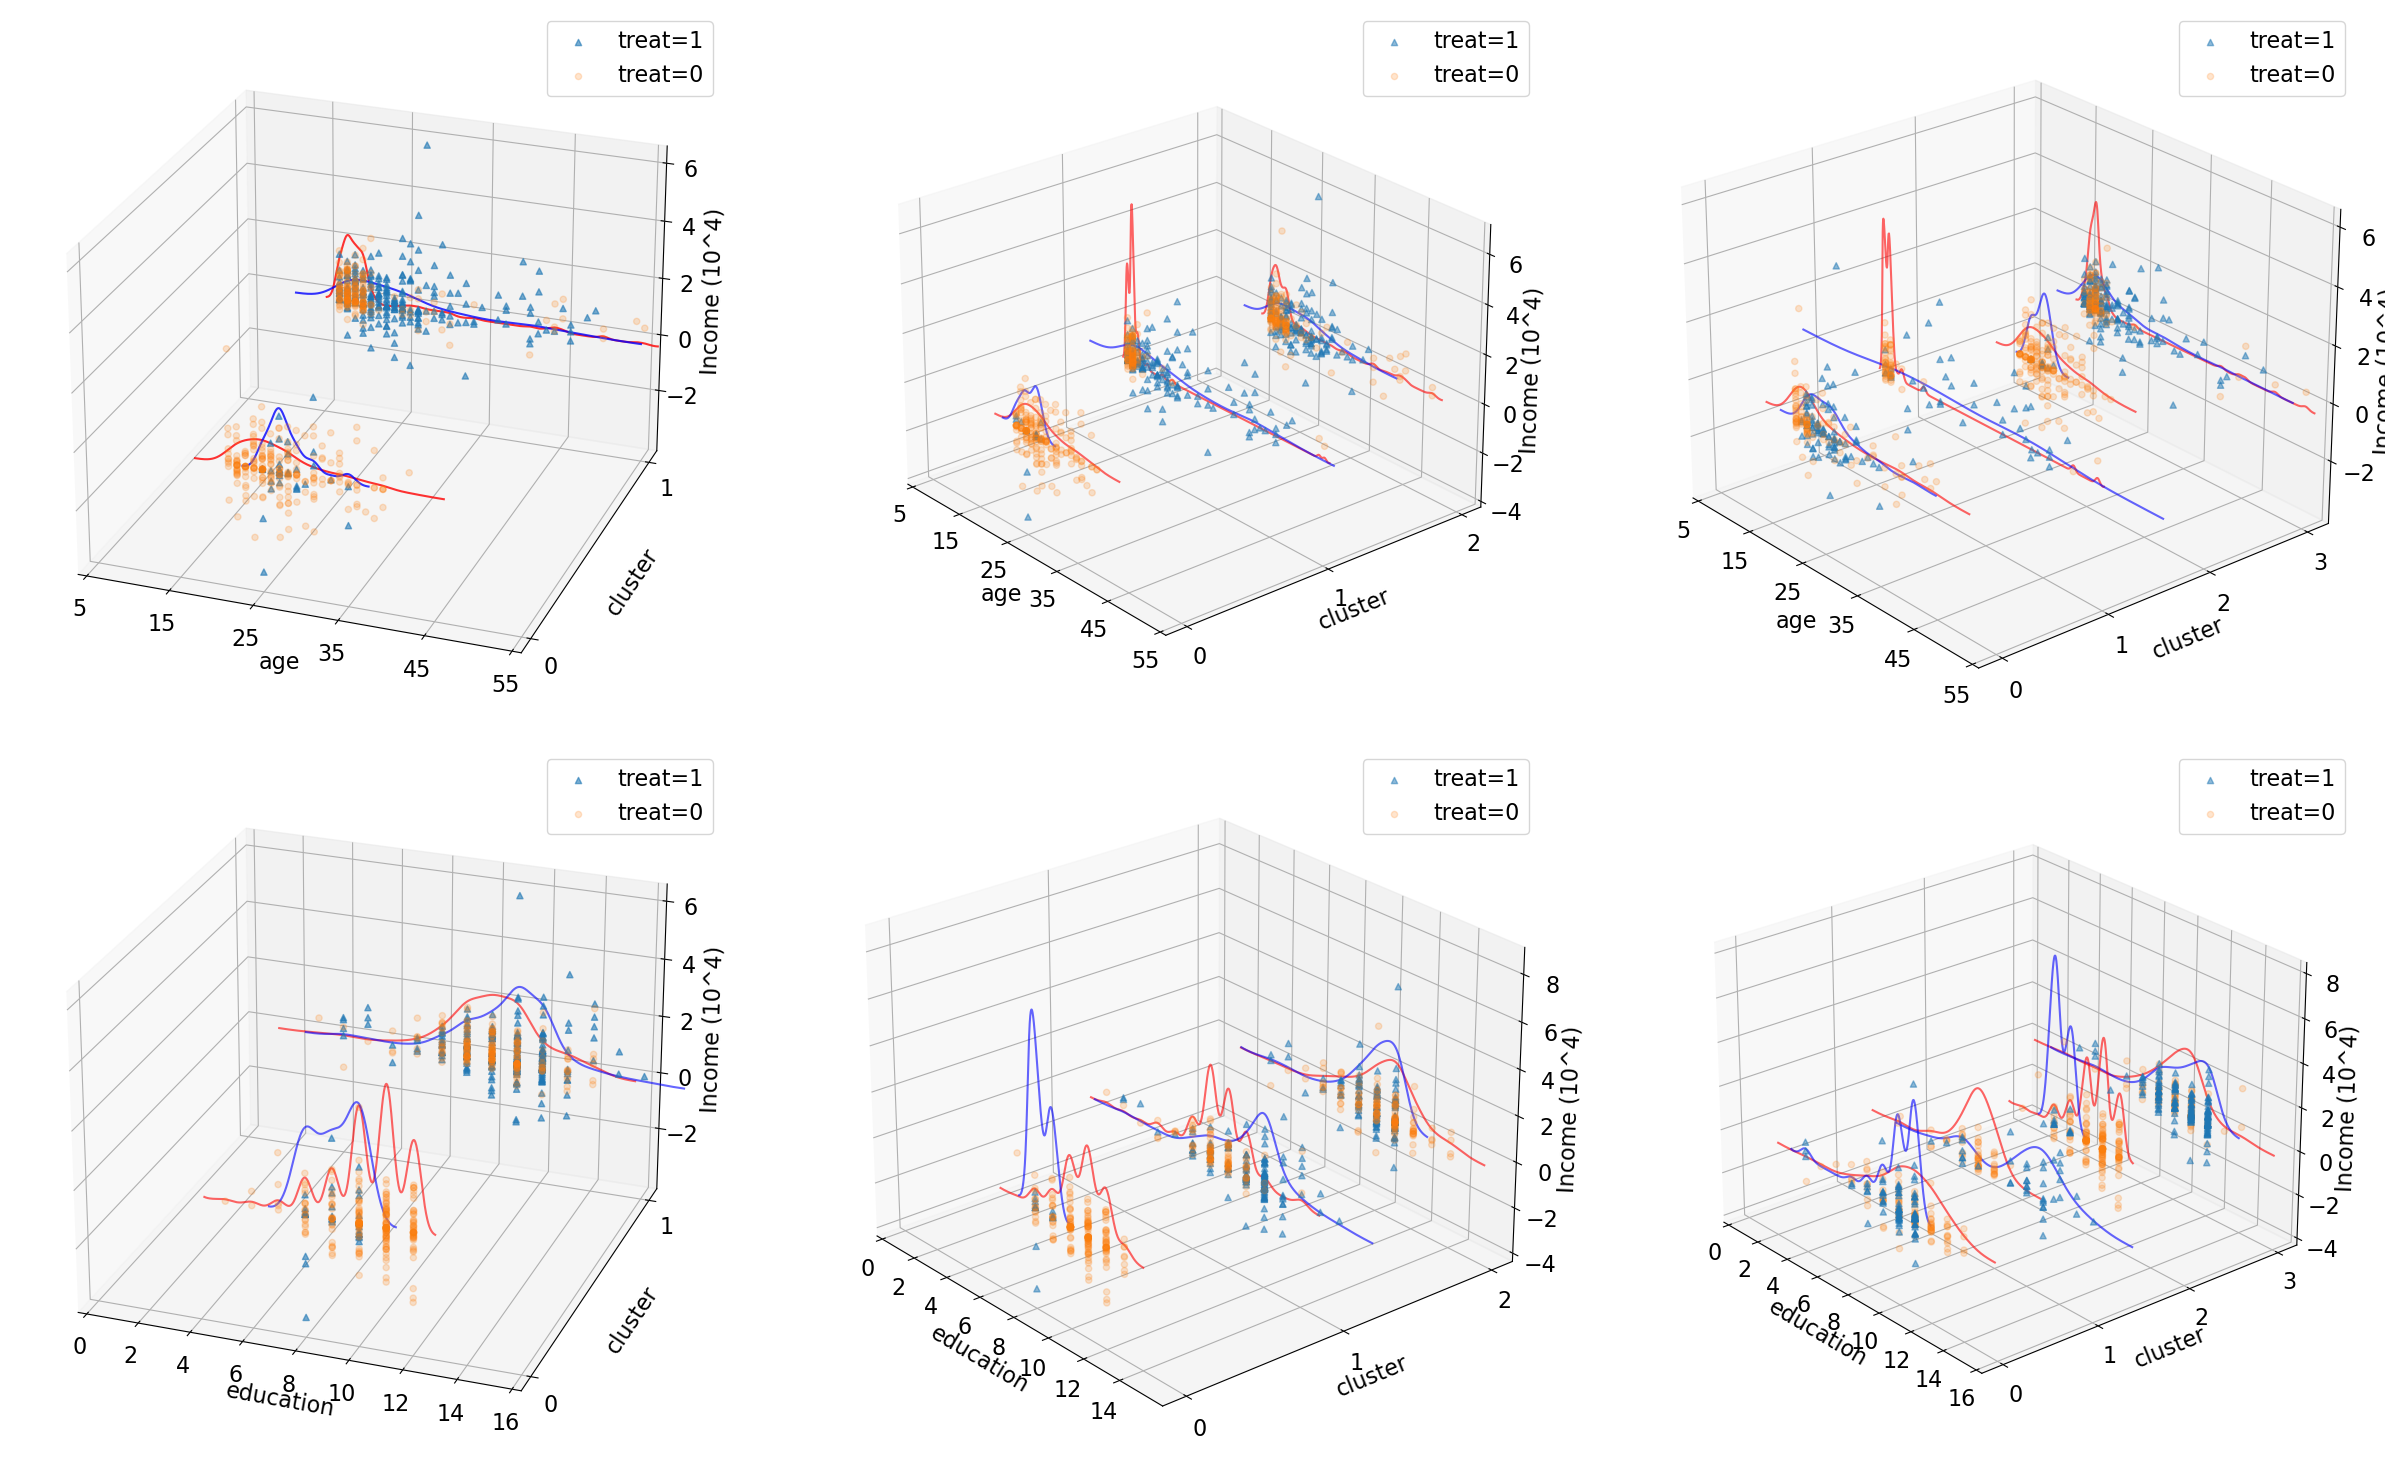

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from statsmodels.nonparametric.kde import KDEUnivariate

fig = plt.figure(figsize=(25,15))

# First subplot (age vs. cluster vs. rediff)
ax = fig.add_subplot(2, 3, 1, projection='3d')

# Plot 'treat=1' first (so it appears behind)
ax.scatter(data_cluster2[data_cluster2['treat'] == 1]['age'], 
           data_cluster2[data_cluster2['treat'] == 1]['cluster'], 
           data_cluster2[data_cluster2['treat'] == 1]['rediff'], 
           marker='^', label='treat=1', alpha=0.6)

# Plot 'treat=0' second (so it appears on top)
ax.scatter(data_cluster2[data_cluster2['treat'] == 0]['age'], 
           data_cluster2[data_cluster2['treat'] == 0]['cluster'], 
           data_cluster2[data_cluster2['treat'] == 0]['rediff'], 
           marker='o', label='treat=0', alpha=0.2)  # Increase alpha for visibility


# kde
for i in data_cluster['cluster'].unique():
    kde = KDEUnivariate(data_cluster2[(data_cluster2['cluster'] == i)&(data_cluster2['treat']==0)]['age'])
    kde.fit()
    ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='red', alpha=0.8)
    kde = KDEUnivariate(data_cluster2[(data_cluster2['cluster'] == i)&(data_cluster2['treat']==1)]['age'])
    kde.fit()
    ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='blue', alpha=0.8)


ax.set_yticks([0, 1])
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
ax.set_xlim(5, max(data_cluster2['age']))
ax.set_xticks(range(5, max(data_cluster2['age'])+1, 10))
ax.set_xlabel('age')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)')
ax.view_init(elev=25, azim=-70)
ax.legend()

# Second subplot (education vs. cluster vs. rediff)
ax = fig.add_subplot(2, 3, 4, projection='3d')

# Plot 'treat=1' first (so it appears behind)
ax.scatter(data_cluster2[data_cluster2['treat'] == 1]['education'], 
           data_cluster2[data_cluster2['treat'] == 1]['cluster'], 
           data_cluster2[data_cluster2['treat'] == 1]['rediff'], 
           marker='^', label='treat=1', alpha=0.6)

# Plot 'treat=0' second (so it appears on top)
ax.scatter(data_cluster2[data_cluster2['treat'] == 0]['education'], 
           data_cluster2[data_cluster2['treat'] == 0]['cluster'], 
           data_cluster2[data_cluster2['treat'] == 0]['rediff'], 
           marker='o', label='treat=0', alpha=0.2)  # Increase alpha for visibility

# kde
for i in data_cluster2['cluster'].unique():
    kde = KDEUnivariate(data_cluster2[(data_cluster2['cluster'] == i)&(data_cluster2['treat']==0)]['education'])
    kde.fit()
    ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='red', alpha=0.6)
    kde = KDEUnivariate(data_cluster2[(data_cluster2['cluster'] == i)&(data_cluster2['treat']==1)]['education'])
    kde.fit()
    ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='blue', alpha=0.6)


ax.set_yticks([0, 1])
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
ax.set_xlim(min(kde.support), max(data_cluster2['education']))
ax.set_xticks(range(0, max(data_cluster2['education'])+1, 2))
ax.set_xlabel('education')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)')
ax.view_init(elev=25, azim=-70)
ax.legend()

##
##

ax = fig.add_subplot(2, 3, 2,projection='3d')
ax.scatter(data_cluster3[data_cluster3['treat']==1]['age'],data_cluster3[data_cluster3['treat']==1]['cluster'], data_cluster3[data_cluster3['treat']==1]['rediff'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster3[data_cluster3['treat']==0]['age'],data_cluster3[data_cluster3['treat']==0]['cluster'], data_cluster3[data_cluster3['treat']==0]['rediff'], marker = 'o', label = 'treat=0', alpha = 0.2)

# kde
for i in data_cluster3['cluster'].unique():
    kde = KDEUnivariate(data_cluster3[(data_cluster3['cluster'] == i)&(data_cluster3['treat']==0)]['age'])
    if len(data_cluster3[(data_cluster3['cluster'] == i)&(data_cluster3['treat']==0)]['age'])>0:
        kde.fit()
        ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='red', alpha=0.6)
    kde = KDEUnivariate(data_cluster3[(data_cluster3['cluster'] == i)&(data_cluster3['treat']==1)]['age'])
    if len(data_cluster3[(data_cluster3['cluster'] == i)&(data_cluster3['treat']==1)]['age'])>0:
        kde.fit()
        ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='blue', alpha=0.6)

# Set y-axis to multiples of 10
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# # label that it is scientific notation
# ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks([0,1,2])
ax.set_xlim(5, max(data_cluster3['age']))
ax.set_xticks(range(5, max(data_cluster3['age'])+1, 10))

ax.set_xlabel('age')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)', rotation=90)
ax.zaxis.labelpad=-0 # <- change the value here
ax.view_init(elev=25, azim=-40)
ax.set_box_aspect(aspect=None, zoom=0.9)
ax.legend()

ax = fig.add_subplot(2, 3, 5,projection='3d')
ax.scatter(data_cluster3[data_cluster3['treat']==1]['education'],data_cluster3[data_cluster3['treat']==1]['cluster'], data_cluster3[data_cluster3['treat']==1]['rediff'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster3[data_cluster3['treat']==0]['education'],data_cluster3[data_cluster3['treat']==0]['cluster'], data_cluster3[data_cluster3['treat']==0]['rediff'], marker = 'o', label = 'treat=0', alpha = 0.2)

# kde
for i in data_cluster3['cluster'].unique():
    kde = KDEUnivariate(data_cluster3[(data_cluster3['cluster'] == i)&(data_cluster3['treat']==0)]['education'])
    if len(data_cluster3[(data_cluster3['cluster'] == i)&(data_cluster3['treat']==0)]['education'])>0:
        kde.fit()
        ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='red', alpha=0.6)
    kde = KDEUnivariate(data_cluster3[(data_cluster3['cluster'] == i)&(data_cluster3['treat']==1)]['education'])
    if len(data_cluster3[(data_cluster3['cluster'] == i)&(data_cluster3['treat']==1)]['education'])>0:
        kde.fit()
        ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='blue', alpha=0.6)

ax.set_yticks([0,1,2])
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
ax.set_xlim(0, max(data_cluster3['education']))
ax.set_xticks(range(0, max(data_cluster3['education'])+1, 2))

ax.set_xlabel('education')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)', rotation=90)
ax.zaxis.labelpad=-0 # <- change the value here
ax.set_xticks(range(0,16,2))
ax.view_init(elev=25, azim=-40)
ax.legend()

##
##


ax = fig.add_subplot(2, 3, 3,projection='3d')
ax.scatter(data_cluster4[data_cluster4['treat']==1]['age'],data_cluster4[data_cluster4['treat']==1]['cluster'], data_cluster4[data_cluster4['treat']==1]['rediff'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster4[data_cluster4['treat']==0]['age'],data_cluster4[data_cluster4['treat']==0]['cluster'], data_cluster4[data_cluster4['treat']==0]['rediff'], marker = 'o', label = 'treat=0', alpha = 0.2)

# kde
for i in data_cluster4['cluster'].unique():
    kde = KDEUnivariate(data_cluster4[(data_cluster4['cluster'] == i)&(data_cluster4['treat']==0)]['age'])
    if len(data_cluster4[(data_cluster4['cluster'] == i)&(data_cluster4['treat']==0)]['age'])>0:
        kde.fit()
        ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='red', alpha=0.6)
    kde = KDEUnivariate(data_cluster4[(data_cluster4['cluster'] == i)&(data_cluster4['treat']==1)]['age'])
    if len(data_cluster4[(data_cluster4['cluster'] == i)&(data_cluster4['treat']==1)]['age'])>0:
        kde.fit()
        ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='blue', alpha=0.6)

# Set y-axis to multiples of 10
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# # label that it is scientific notation
# ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks([0,1,2,3])
ax.set_xlim(5, max(data_cluster4['age']))
ax.set_xticks(range(5, max(data_cluster4['age'])+1, 10))
ax.set_xlabel('age')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)', rotation=90)
ax.zaxis.labelpad=-0 # <- change the value here
ax.view_init(elev=25, azim=-40)
ax.legend()

ax = fig.add_subplot(2, 3, 6,projection='3d')
ax.scatter(data_cluster4[data_cluster4['treat']==1]['education'],data_cluster4[data_cluster4['treat']==1]['cluster'], data_cluster4[data_cluster4['treat']==1]['rediff'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster4[data_cluster4['treat']==0]['education'],data_cluster4[data_cluster4['treat']==0]['cluster'], data_cluster4[data_cluster4['treat']==0]['rediff'], marker = 'o', label = 'treat=0', alpha = 0.2)

for i in data_cluster4['cluster'].unique():
    kde = KDEUnivariate(data_cluster4[(data_cluster4['cluster'] == i)&(data_cluster4['treat']==0)]['education'])
    if len(data_cluster4[(data_cluster4['cluster'] == i)&(data_cluster4['treat']==0)]['education'])>0:
        kde.fit()
        ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='red', alpha=0.6)
    kde = KDEUnivariate(data_cluster4[(data_cluster4['cluster'] == i)&(data_cluster4['treat']==1)]['education'])
    if len(data_cluster4[(data_cluster4['cluster'] == i)&(data_cluster4['treat']==1)]['education'])>0:
        kde.fit()
        ax.plot(kde.support, i*np.ones_like(kde.support), kde.density*10e4, color='blue', alpha=0.6)

ax.set_yticks([0,1,2,3])
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))

ax.set_xlabel('education')
ax.set_ylabel('cluster')
ax.set_zlabel('Income (10^4)', rotation=90)
ax.zaxis.labelpad=-0 # <- change the value here
ax.set_xlim(0, max(data_cluster4['education']))
ax.set_xticks(range(0, max(data_cluster4['education'])+1, 2))
ax.view_init(elev=25, azim=-40)
ax.legend()

# reduce the vertical space between the two subplots
plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0.1)

plt.tight_layout()


ax.set_box_aspect(aspect=None, zoom=0.9)

# save
plt.savefig('output/nsw_3d.png')

plt.show()


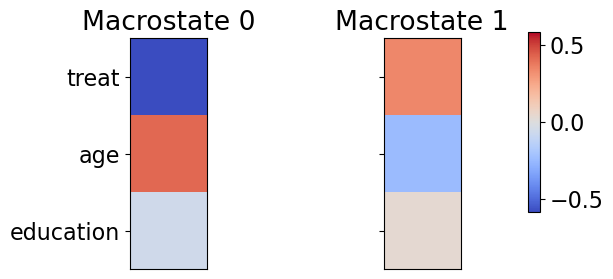

In [105]:
# visualize cause side macrostates
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0028', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

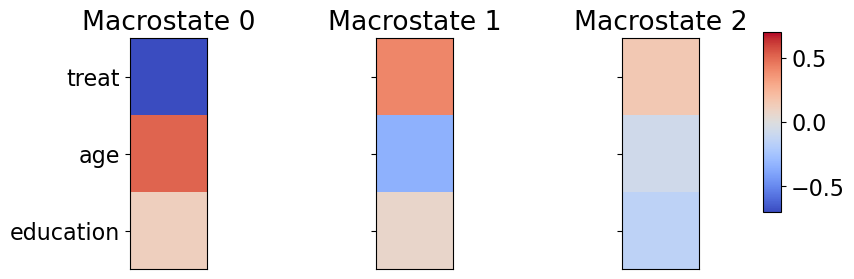

In [106]:
# visualize cause side macrostates
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0029', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

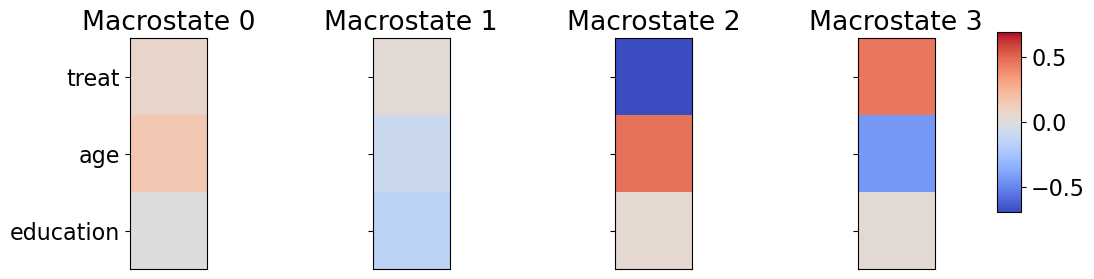

In [107]:
# visualize cause side macrostates
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0030', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

# Binning Analysis

In [3]:
import numpy as np
import pandas as pd

# read stata file
data = pd.read_stata('nsw.dta')
data = data.drop(columns=['data_id'])

In [ ]:
tab = []

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

for i in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]:
    data = data.dropna()
    Y = (data['re78']-data['re75']).values.reshape(-1, 1)
    Y = pd.qcut(Y.flatten(), i, labels=False, duplicates='drop').reshape(-1, 1)
    X = data[['treat','age', 'education']].values
    import sklearn.preprocessing as skp
    scaler = skp.StandardScaler()
    X = scaler.fit_transform(X)
    in_sample_idx, out_sample_idx = train_test_split(np.arange(X.shape[0]),
                                                    train_size=0.75,
                                                    random_state=42)

    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    trial = study.best_trial

    def build_optimized_model():
        # vary number of layers
        n_layers = study.best_trial.params['n_layers']
        model = Sequential()
        for i in range(n_layers):
            # vary size of each layer
            num_hidden = study.best_trial.params[f'n_units_l{i}']
            model.add(Dense(num_hidden, activation="relu"))
            # vary amount of dropout for each layer
            dropout = study.best_trial.params[f'dropout_l{i}']
            model.add(Dropout(rate=dropout))

        # add output layer with size of target
        model.add(Dense(Y.shape[1], activation="linear"))
        return model

    data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

    CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
    }

    cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 4},
        'verbose' : 0}
    # effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
    #     'verbose' : 0}

    block_names = ['CondDensityEstimator', 'CauseClusterer']
    block_params = [CDE_params, cause_cluster_params]

    my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

    train_results = my_exp.train()

    import pandas as pd
    data_cluster = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
    data_lbs = pd.DataFrame(train_results['CauseClusterer']['x_lbls'])
    data_lbs.to_csv('data_lbs_'+str(i)+'.csv')
    data_cluster['rediff'] = data_cluster['re78']-data_cluster['re75']
    # for each cluster, calculate the difference between the proportion of treated and untreated units
    treat_max = data_cluster.groupby('cluster')['treat'].mean().min()
    tab.append([i, treat_max])
    print(i)

In [ ]:
tab = []

for i in [10, 30, 50, 70, 100, 150, 200, 250]:
    data = data.dropna()
    Y = (data['re78']-data['re75']).values.reshape(-1, 1)
    Y = pd.qcut(Y.flatten(), i, labels=False, duplicates='drop').reshape(-1, 1)
    k = len(np.unique(Y))
    X = data[['treat','age', 'education']].values
    import sklearn.preprocessing as skp
    scaler = skp.StandardScaler()
    X = scaler.fit_transform(X)
    in_sample_idx, out_sample_idx = train_test_split(np.arange(X.shape[0]),
                                                    train_size=0.75,
                                                    random_state=42)

    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    trial = study.best_trial

    def build_optimized_model():
        # vary number of layers
        n_layers = study.best_trial.params['n_layers']
        model = Sequential()
        for i in range(n_layers):
            # vary size of each layer
            num_hidden = study.best_trial.params[f'n_units_l{i}']
            model.add(Dense(num_hidden, activation="relu"))
            # vary amount of dropout for each layer
            dropout = study.best_trial.params[f'dropout_l{i}']
            model.add(Dropout(rate=dropout))

        # add output layer with size of target
        model.add(Dense(Y.shape[1], activation="linear"))
        return model

    data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

    CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
    }

    cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 4},
        'verbose' : 0}
    # effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
    #     'verbose' : 0}

    block_names = ['CondDensityEstimator', 'CauseClusterer']
    block_params = [CDE_params, cause_cluster_params]

    my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

    train_results = my_exp.train()

    import pandas as pd
    data_cluster = pd.merge(data, pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})
    data_cluster['rediff'] = data_cluster['re78']-data_cluster['re75']
    # for each cluster, calculate the difference between the proportion of treated and untreated units
    treat_diff = (data_cluster.groupby('cluster')['treat'].mean() - (1-data_cluster.groupby('cluster')['treat'].mean())).abs().mean()
    tab.append([k, treat_diff])
    print(i)

In [32]:
Y = (data['re78']-data['re75']).values.reshape(-1, 1)
len(np.unique(pd.qcut(Y.flatten(), 500, labels=False, duplicates='drop').reshape(-1, 1)))

435

In [33]:
for i in [300, 350, 400, 450, 500]:
    Y = (data['re78']-data['re75']).values.reshape(-1, 1)
    print(len(np.unique(pd.qcut(Y.flatten(), i, labels=False, duplicates='drop').reshape(-1, 1))))

262
305
348
392
435


In [30]:
tab

[[50, 0.3169811320754717],
 [100, 0.29901960784313725],
 [150, 0.02459016393442623],
 [200, 0.2391304347826087],
 [250, 0.0],
 [300, 0.31135531135531136],
 [350, 0.10232558139534884],
 [400, 0.2066115702479339],
 [450, 0.32710280373831774],
 [500, 0.0]]

In [42]:
import pandas as pd

# Convert the list to a DataFrame
tab

[[10, 0.32116282886431347],
 [27, 0.12902831990532232],
 [45, 0.33602612669781873],
 [62, 0.22995953223187476],
 [88, 0.29203796094241385],
 [131, 0.19784603692756675],
 [174, 0.32014318091426197],
 [218, 0.22106872110042952],
 [262, 0.31135531135531136],
 [305, 0.10232558139534884],
 [348, 0.2066115702479339],
 [392, 0.32710280373831774],
 [435, 0.0]]

In [36]:
(data_cluster.groupby('cluster')['treat'].mean() - (1-data_cluster.groupby('cluster')['treat'].mean())).abs().mean()

0.2025357022540899